In [ ]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime, os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load and Preprocess Images

In [ ]:
path ='/content/drive/My Drive/lfw/**/*.jpg' 
face_images = glob.glob(path) #returns path of images
 
print(len(face_images)) #contains 13243 images

print(face_images[:2], len(face_images))

13232
['/content/drive/My Drive/lfw/Roel_Campos/Roel_Campos_0001.jpg', '/content/drive/My Drive/lfw/Rod_Thorn/Rod_Thorn_0001.jpg'] 13232


In [ ]:
with open('face_images_path.pickle','wb') as f:
    pickle.dump(face_images,f)

### The size of original images are of 250 x 250 pixels. However, it would take a lot computation power to process these images on normal computer. Therefore, we will reduce the size of all images to 80 x 80 pixels.

    As there are around 13,000 images, it would take lot of time if we process it individually. Hence, we take advantage of multiprocessing library provided in python for ease of execution.

    tqdm is a progress library that we use to get a progress bar of the work done.

In [ ]:
from tqdm import tqdm   

In [ ]:
from multiprocessing import Pool 
progress = tqdm(total= len(face_images), position=0)
def read(path):
    img = image.load_img(path, target_size=(80,80,3))
    img = image.img_to_array(img)
    img = img/255.
    progress.update(1)
    return img

img_array=[]
for i in range(len(face_images)) :
    img_array.append( read(face_images[i]) )
 

100%|██████████| 13232/13232 [2:32:07<00:00,  1.47it/s]

### Stor img_array (contains images) with the help of pickle library:

In [ ]:
with open('img_array.pickle','wb') as f:
    pickle.dump(img_array, f)

In [ ]:
len(img_array)

13232

In [ ]:
cd /content/drive/My Drive 

/content/drive/My Drive


In [ ]:
with open('img_array.pickle','rb') as f:
    img_array = pickle.load(f)

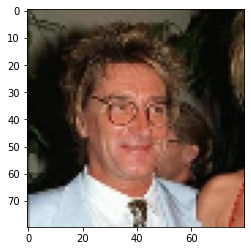

In [ ]:
plt.imshow(img_array[12])

In [ ]:
print(img_array[12])

[[[0.21960784 0.21960784 0.18039216]
  [0.3254902  0.32156864 0.24313726]
  [0.4        0.39215687 0.30980393]
  ...
  [0.11764706 0.10196079 0.06666667]
  [0.10196079 0.07843138 0.01568628]
  [0.19215687 0.16078432 0.10980392]]

 [[0.3019608  0.3019608  0.2627451 ]
  [0.23529412 0.23137255 0.15294118]
  [0.43137255 0.42352942 0.34117648]
  ...
  [0.17254902 0.14117648 0.09019608]
  [0.35686275 0.3137255  0.24313726]
  [0.2        0.14901961 0.08627451]]

 [[0.25490198 0.25490198 0.21568628]
  [0.44313726 0.4392157  0.36078432]
  [0.19607843 0.1882353  0.10588235]
  ...
  [0.28235295 0.23137255 0.15686275]
  [0.3019608  0.23921569 0.14901961]
  [0.24313726 0.16862746 0.10980392]]

 ...

 [[0.5803922  0.62352943 0.6392157 ]
  [0.8156863  0.8862745  0.9254902 ]
  [0.8235294  0.9019608  0.94509804]
  ...
  [0.7019608  0.40784314 0.28235295]
  [0.7294118  0.41960785 0.29803923]
  [0.7529412  0.44313726 0.3137255 ]]

 [[0.58431375 0.627451   0.6431373 ]
  [0.827451   0.8980392  0.9372549 ]


In [ ]:
all_images = np.array(img_array)

## Data preparation for Model Training

### Split dataset to train and validation set. We will use train data to train our model and validation data will be used to evaluate the model.

In [ ]:
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [ ]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)##inter_Cubic
  
    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)

    low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

    return low_res_image

## The idea is to take these distorted images and feed it to our model and make model learn to get the original image back.

In [ ]:
train_x_px = []

for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set


val_x_px = []

for i in range(val_x.shape[0]):
    temp = pixalate_image(val_x[i,:,:,:])
    val_x_px.append(temp)

val_x_px = np.array(val_x_px)

(80, 80, 3)
[[[0.20392157 0.19215687 0.11764706]
  [0.23921569 0.21960784 0.13333334]
  [0.27450982 0.24705882 0.14509805]
  ...
  [0.26666668 0.21960784 0.17254902]
  [0.27058825 0.20784314 0.15686275]
  [0.33333334 0.22352941 0.18039216]]

 [[0.18431373 0.17254902 0.09803922]
  [0.21568628 0.19607843 0.10980392]
  [0.24313726 0.21960784 0.1254902 ]
  ...
  [0.26666668 0.21176471 0.16862746]
  [0.26666668 0.20392157 0.15294118]
  [0.30980393 0.2        0.15294118]]

 [[0.15294118 0.14117648 0.08235294]
  [0.1764706  0.16470589 0.09019608]
  [0.20392157 0.18431373 0.09803922]
  ...
  [0.27450982 0.21176471 0.16078432]
  [0.27058825 0.2        0.14509805]
  [0.29803923 0.1882353  0.14117648]]

 ...

 [[0.7372549  0.7490196  0.76862746]
  [0.7411765  0.75686276 0.76862746]
  [0.7411765  0.75686276 0.7607843 ]
  ...
  [0.77254903 0.78431374 0.84313726]
  [0.77254903 0.8039216  0.84705883]
  [0.40784314 0.44705883 0.48235294]]

 [[0.7254902  0.7372549  0.75686276]
  [0.73333335 0.7490196  

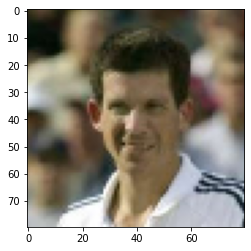

In [ ]:
plt.imshow(train_x[20])
print(train_x[20].shape)
print(train_x[20])

print("Originale Image")

(80, 80, 3)
[[[0.21082354 0.19403923 0.11278432]
  [0.21082354 0.19403923 0.11278432]
  [0.24956864 0.21364708 0.1352157 ]
  ...
  [0.2939608  0.22619611 0.17537257]
  [0.28800002 0.20768629 0.15952943]
  [0.28800002 0.20768629 0.15952943]]

 [[0.21082354 0.19403923 0.11278432]
  [0.21082354 0.19403923 0.11278432]
  [0.24956864 0.21364708 0.1352157 ]
  ...
  [0.2939608  0.22619611 0.17537257]
  [0.28800002 0.20768629 0.15952943]
  [0.28800002 0.20768629 0.15952943]]

 [[0.16941178 0.1642353  0.096     ]
  [0.16941178 0.1642353  0.096     ]
  [0.19780393 0.17898041 0.11105883]
  ...
  [0.30760786 0.23341179 0.17835295]
  [0.29474512 0.20925492 0.15623531]
  [0.29474512 0.20925492 0.15623531]]

 ...

 [[0.7405491  0.7513726  0.7621962 ]
  [0.7405491  0.7513726  0.7621962 ]
  [0.73835295 0.7483922  0.7523138 ]
  ...
  [0.6865883  0.709804   0.7559216 ]
  [0.62839216 0.65945107 0.7016471 ]
  [0.62839216 0.65945107 0.7016471 ]]

 [[0.7301962  0.7443137  0.7589021 ]
  [0.7301962  0.7443137  

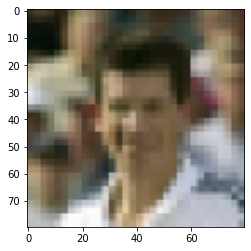

In [ ]:
plt.imshow(train_x_px[20])
print(train_x_px[20].shape)
print(train_x_px[20])

print("Input Image")

# Model building

## Let's define the structure of model. Moreover, to overcome the possibility of over-fitting, we are using l1 regularization technique in our convolution layer.

In [ ]:
Input_img = Input(shape=(80, 80, 3))  

#*****************************************************encoding architecture*****************************************************

x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
x3 = MaxPool2D(padding='same')(x2)

x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
x6 = MaxPool2D(padding='same')(x5)

encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)


#*****************************************************decoding architecture*****************************************************

x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
x10 = Add()([x5, x9])

x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
x14 = Add()([x2, x13])

# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## we can modify the model to get better results. we can change number of layers, number of units or some regularization techniques too.  

In [ ]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### Checkpoint

# Model Training

### We will first define some callbacks so that it would be easy for model visualization and evaluation in future.

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('superResolution_checkpoint3.h5',save_best_only=True)

In [ ]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

# Let's train our model:

![image.png](attachment:image.png)

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
autoencoder.load_weights("/content/drive/My Drive/superResolution_checkpoint3.h5")

In [ ]:
history = autoencoder.fit(train_x_px,train_x,
            epochs=100,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper, model_checkpoint,tensorboard_callback])

Epoch 1/100
331/331 [==============================] - 93s 280ms/step - loss: 0.0057 - accuracy: 0.8576 - val_loss: 0.0028 - val_accuracy: 0.8885
Epoch 2/100
331/331 [==============================] - 89s 269ms/step - loss: 0.0026 - accuracy: 0.8985 - val_loss: 0.0026 - val_accuracy: 0.9089
Epoch 3/100
331/331 [==============================] - 87s 263ms/step - loss: 0.0025 - accuracy: 0.9035 - val_loss: 0.0025 - val_accuracy: 0.9026
Epoch 4/100
331/331 [==============================] - 90s 271ms/step - loss: 0.0024 - accuracy: 0.9071 - val_loss: 0.0024 - val_accuracy: 0.8999
Epoch 5/100
331/331 [==============================] - 92s 278ms/step - loss: 0.0023 - accuracy: 0.9077 - val_loss: 0.0024 - val_accuracy: 0.9080
Epoch 6/100
331/331 [==============================] - 88s 264ms/step - loss: 0.0023 - accuracy: 0.9083 - val_loss: 0.0023 - val_accuracy: 0.9107
Epoch 7/100
331/331 [==============================] - 89s 270ms/step - loss: 0.0023 - accuracy: 0.9112 - val_loss: 0.0023 -

In [ ]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 2251), started 0:23:41 ago. (Use '!kill 2251' to kill it.)

<IPython.core.display.Javascript object>

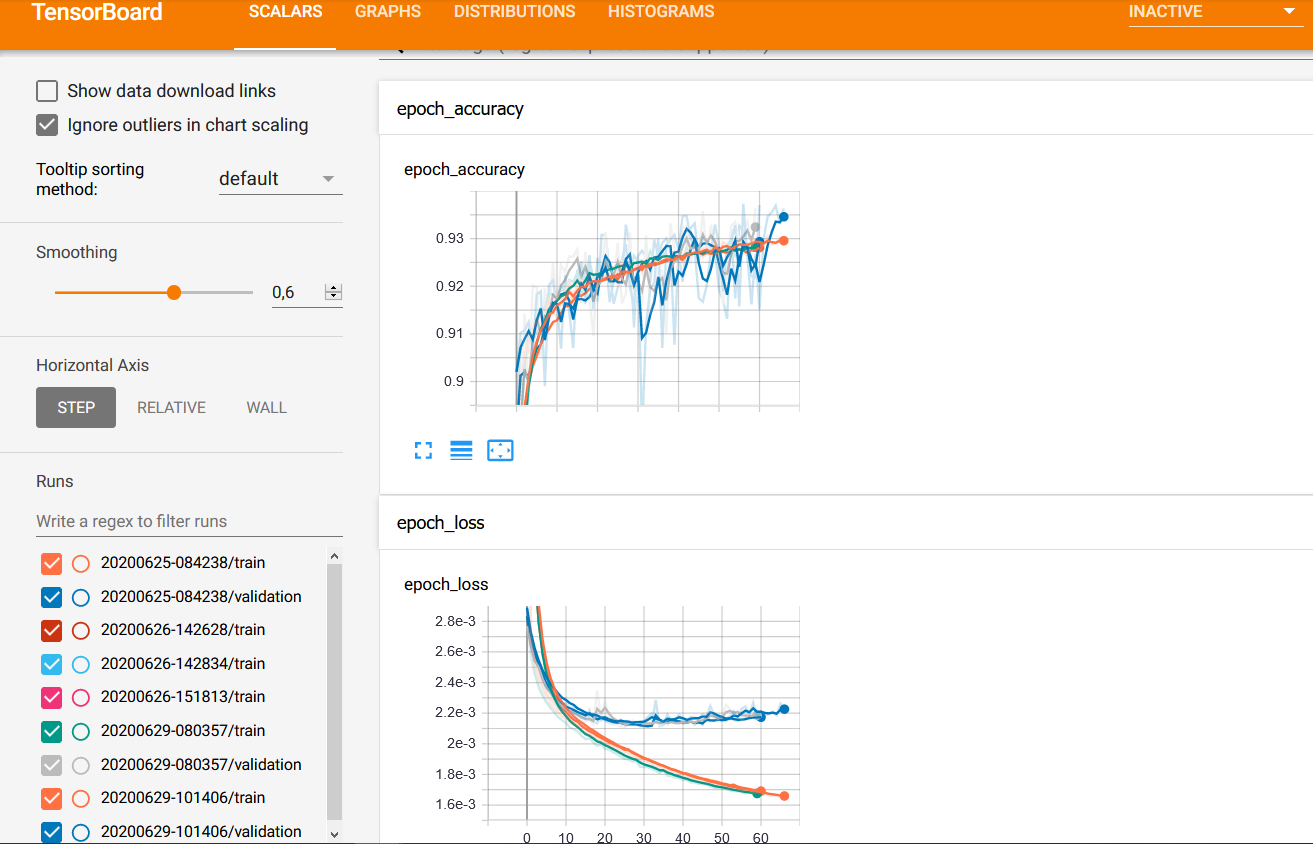

In [ ]:
predictions = autoencoder.predict(val_x_px)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


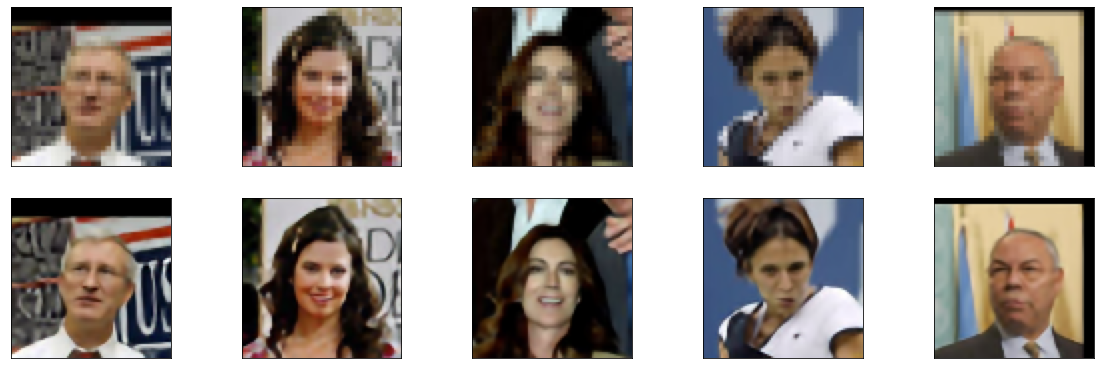

In [ ]:
n = 5
plt.figure(figsize= (20,10))
 
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+30])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
 
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+30])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
 
 
plt.show()

In [ ]:
results = autoencoder.evaluate(val_x_px, val_x)
print('loss, accuracy', results)

83/83 [==============================] - 7s 88ms/step - loss: 0.0021 - accuracy: 0.9275
loss, accuracy [0.0021106398198753595, 0.927480936050415]


In [ ]:
cd Test/

/content/drive/My Drive/Test


In [ ]:
img = image.load_img('Wolfgang_Schuessel_0001.jpg', target_size=(80,80,3))
img = image.img_to_array(img)
img = img/255.

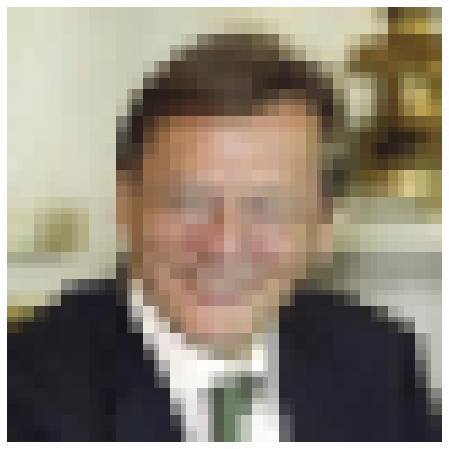

In [ ]:
img_LR = pixalate_image(img)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img_LR)



In [ ]:
input_array = np.array([img_LR])
print(input_array.shape)

(1, 80, 80, 3)


In [ ]:
predict = autoencoder.predict(input_array)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


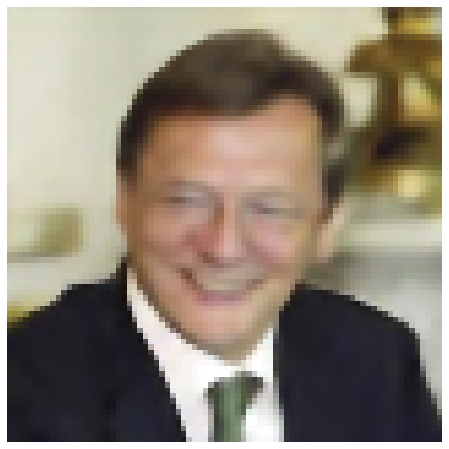

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(predict[0])

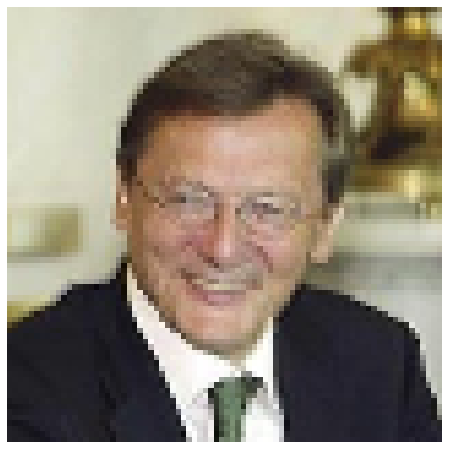

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(img)
 

In [ ]:
from math import log10, sqrt 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
psnr=PSNR(predict, img)
print(psnr) 

76.43739862119114


In [ ]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
s = measure.compare_ssim(predict[0], img , multichannel=True)
print(s)

0.9504421832223787


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.


In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [ ]:
a = mse(input_array[0], predict[0])
print(a)

0.011056562881020032
